# Experiments for the Eikonal equation in a d-dimensional ball with different sampling distributions

In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
import torch
from time import time as t

import sys
# setting path
sys.path.append('../')

from visualization.plots_disc import plot_2d_proj_disc
from Hamiltonians.Eikonal_LxF import Eikonal_sq_LF_multiD
from PointSampling.Ball import data_gen_ball, data_gen_ball_unif
from NeuralNetworks.NNs import FCFF_3L

#Right-hand-side of the PDE
def f(X):    
    return 1

#Boundary condition
def g(X):    
    return 0


training_params = {
    'numerical_scheme': Eikonal_sq_LF_multiD,

    'f': f,
    'g': g,
    'c': None,
    
    'beta': 0.,  ## parameter for the +u_i term
    
    'lambda': 1. #weight parameter for the boundary loss
    }

In [2]:
# Dimension of the d-dimensional ball for each experiment
dim_list = 6*[10]
# Architecture in each experiment
arch_list = 2*[2*[30], 
               2*[40], 
               2*[60]]
# Sampling distribution: 0 for uniform distribution and 1 for radially uniform distribution
distr_list = 3*[0] + 3*[1]


n_experiments = len(dim_list)
radii = [6., 0.]

# Parameters for each experiment
delta_list = [[.7, .3, .1]]*n_experiments
alpha_list = [[2.5, 1., .1]]*n_experiments
rounds = len(delta_list[0])

N_col_list = [[200]*rounds]*n_experiments
N_b_list = [[80]*rounds]*n_experiments


num_iterations_list = 2*[[1000, 1000, 1000],
                       [1000, 2000, 3000],
                       [2000, 2000, 4000]] 

100%|██████████| 1000/1000 [00:02<00:00, 333.76it/s]


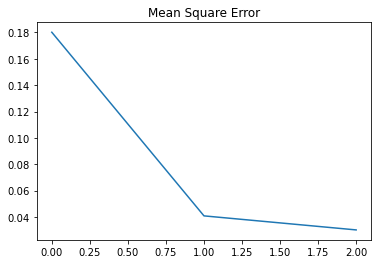

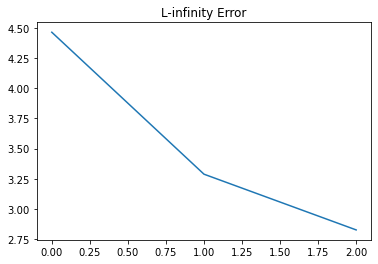

/Users/carlosesteveyague/anaconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666647174771/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


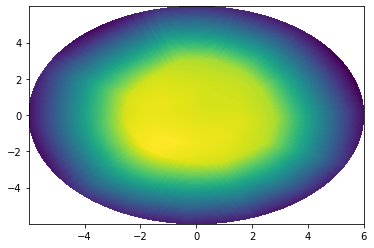

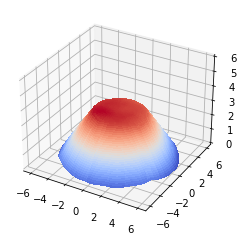

100%|██████████| 3000/3000 [00:09<00:00, 320.18it/s]


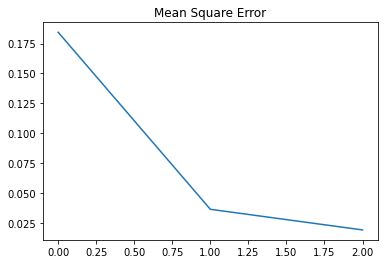

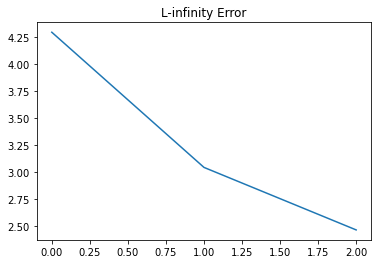

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


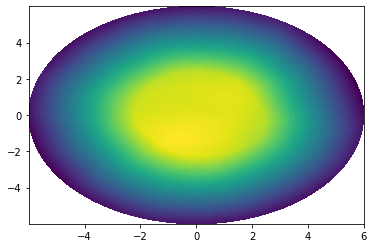

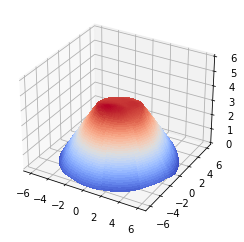

100%|██████████| 4000/4000 [00:14<00:00, 273.92it/s]


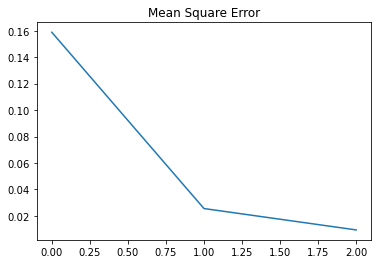

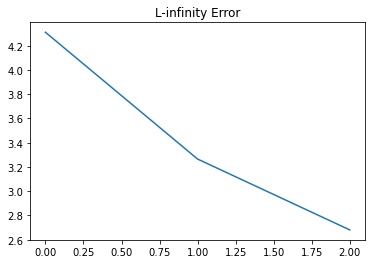

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


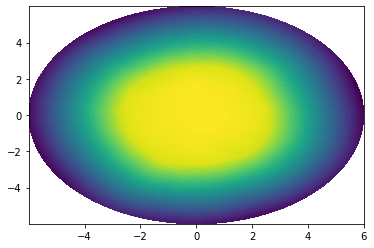

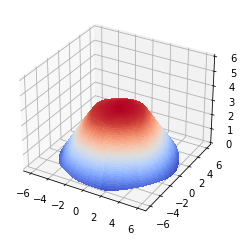

100%|██████████| 1000/1000 [00:03<00:00, 329.01it/s]


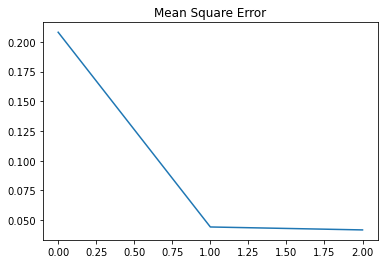

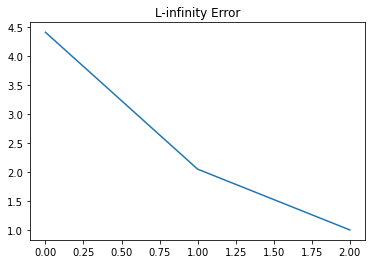

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


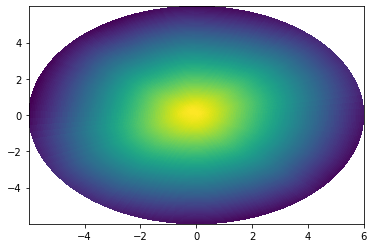

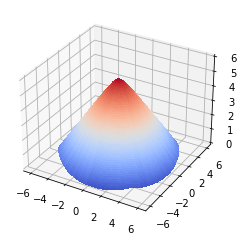

100%|██████████| 3000/3000 [00:09<00:00, 323.34it/s]


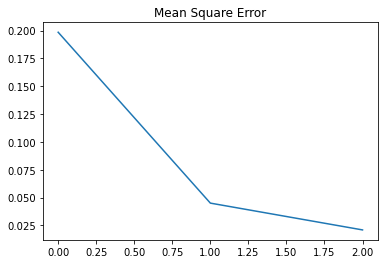

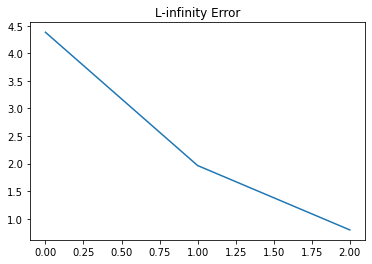

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


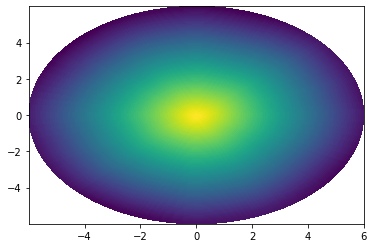

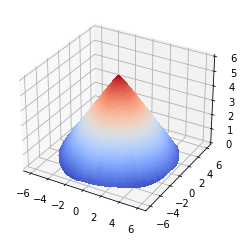

100%|██████████| 4000/4000 [00:15<00:00, 258.54it/s]


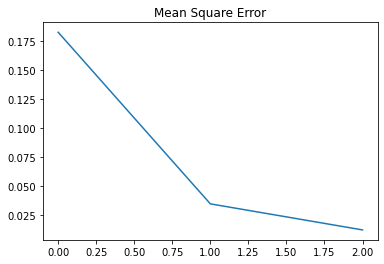

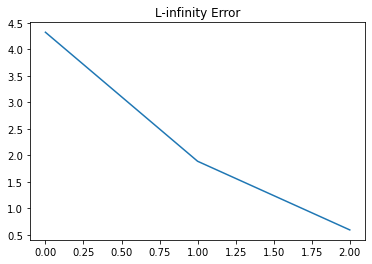

../visualization/plots_disc.py:42: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(GridX.detach(), GridY.detach(), V.detach())


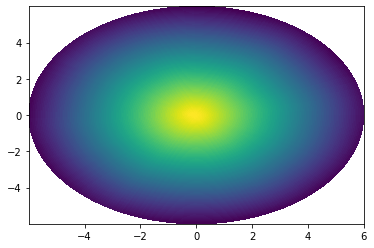

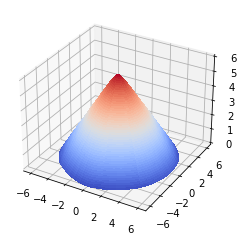

In [3]:
from Training.training import train
from error_test.disc_error import error_ball

MSE_history = torch.zeros([n_experiments, rounds])
L_inf_error_history = torch.zeros([n_experiments, rounds])
run_times = torch.zeros([n_experiments])


for j in range(n_experiments):
    
    if distr_list[j] == 0:
        domain = data_gen_ball_unif(radii, dim_list[j])
    elif distr_list[j] == 1:
        domain = data_gen_ball(radii, dim_list[j])
        
    if len(arch_list[j]) == 2:        
        NN = FCFF_3L([dim_list[j]] + arch_list[j])
    else:
        NN = FCFF_4L([dim_list[j]] + arch_list[j])
        
    training_params['optimizer'] = optim.SGD(NN.parameters(), lr = .02, momentum = .2)
    
    time = 0.
    
    for i in range(rounds):
    
        training_params['alpha'] = alpha_list[j][i]
        training_params['delta'] = delta_list[j][i]
        
        training_params['n_coloc_points'] = N_col_list[j][i]
        training_params['n_boundary_points'] = N_b_list[j][i]
        training_params['num_iterations'] = num_iterations_list[j][i]
        
        t0 = t()
        total_loss, PDE_loss, boundary_loss = train(NN, domain, training_params)
        time += t() - t0
        
        MC_points = int(1e6) # Number of grid points for comparison with the ground truth
        MSE, L_inf = error_ball(NN, max(radii), MC_points)
        
        MSE_history[j,i] = MSE
        L_inf_error_history[j,i] = L_inf
    
    run_times[j] = time
    
    plt.plot(MSE_history[j])
    plt.title('Mean Square Error')
    plt.show()
    
    plt.plot(L_inf_error_history[j])
    plt.title('L-infinity Error')
    plt.show()
    
    X_axis = 0
    Y_axis = 1

    n_theta = 100
    n_r = 100
    plot_2d_proj_disc(X_axis, Y_axis, NN, n_theta, n_r, radii)

In [4]:
import pandas as pd
import numpy as np

distr_list_tab = []

for i in range(len(distr_list)):
    if distr_list[i]==0:
        distr_list_tab.append('Unif')
    elif distr_list[i]==1:
        distr_list_tab.append('Rad')
    

training_features = pd.DataFrame({'Dimension': dim_list,
                               'Distribution': distr_list_tab,
                               'Architecture': arch_list,
                               'delta': delta_list,
                               'alpha': alpha_list,
                               'N': N_col_list,
                               'N_b': N_b_list,
                               'Iterations': num_iterations_list})

run_T = pd.DataFrame({'Runtime (s)': np.array(run_times)}).round(1)

results_MSE = pd.DataFrame(np.array(MSE_history))
results_Linf = pd.DataFrame(np.array(L_inf_error_history))


display('Mean Square Error', training_features.join(results_MSE).join(run_T).transpose())
display('L-infinity Error', training_features.join(results_Linf).join(run_T).transpose())

# One table
MSE = np.expand_dims(np.array(MSE_history[:,-1]), axis = 1)
L_inf_error = np.expand_dims(np.array(L_inf_error_history[:,-1]), axis = 1)
errors = np.concatenate((MSE, L_inf_error), axis = 1)
results = pd.DataFrame(errors,  columns = ['MSE', 'L_inf'])

display(training_features.join(results).join(run_T).transpose())

'Mean Square Error'

,0,1,2,3,4,5
Dimension,10,10,10,10,10,10
Distribution,Unif,Unif,Unif,Rad,Rad,Rad
Architecture,"[30, 30]","[40, 40]","[60, 60]","[30, 30]","[40, 40]","[60, 60]"
delta,"[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]"
alpha,"[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]"
N,"[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]"
N_b,"[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]"
Iterations,"[1000, 1000, 1000]","[1000, 2000, 3000]","[2000, 2000, 4000]","[1000, 1000, 1000]","[1000, 2000, 3000]","[2000, 2000, 4000]"
0,0.180114,0.184543,0.158826,0.20807,0.198567,0.18253
1,0.0408645,0.0362644,0.0255941,0.0442352,0.044994,0.0343513


'L-infinity Error'

,0,1,2,3,4,5
Dimension,10,10,10,10,10,10
Distribution,Unif,Unif,Unif,Rad,Rad,Rad
Architecture,"[30, 30]","[40, 40]","[60, 60]","[30, 30]","[40, 40]","[60, 60]"
delta,"[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]"
alpha,"[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]"
N,"[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]"
N_b,"[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]"
Iterations,"[1000, 1000, 1000]","[1000, 2000, 3000]","[2000, 2000, 4000]","[1000, 1000, 1000]","[1000, 2000, 3000]","[2000, 2000, 4000]"
0,4.46339,4.29388,4.31073,4.41095,4.381,4.32476
1,3.28729,3.04326,3.26505,2.04793,1.96385,1.89063


,0,1,2,3,4,5
Dimension,10,10,10,10,10,10
Distribution,Unif,Unif,Unif,Rad,Rad,Rad
Architecture,"[30, 30]","[40, 40]","[60, 60]","[30, 30]","[40, 40]","[60, 60]"
delta,"[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]","[0.7, 0.3, 0.1]"
alpha,"[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]","[2.5, 1.0, 0.1]"
N,"[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]","[200, 200, 200]"
N_b,"[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]","[80, 80, 80]"
Iterations,"[1000, 1000, 1000]","[1000, 2000, 3000]","[2000, 2000, 4000]","[1000, 1000, 1000]","[1000, 2000, 3000]","[2000, 2000, 4000]"
MSE,0.0302154,0.019003,0.00944398,0.0417608,0.0209028,0.0118509
L_inf,2.82543,2.46482,2.68078,0.998672,0.796472,0.595185


In [5]:
display(training_features.join(results_MSE).join(run_T).to_latex())

display(training_features.join(results_Linf).join(run_T).to_latex())

display(training_features.join(results).join(run_T).to_latex())

'\\begin{tabular}{lrlllllllrrrr}\n\\toprule\n{} &  Dimension & Distribution & Architecture &            delta &            alpha &                N &           N\\_b &          Iterations &         0 &         1 &         2 &  Runtime (s) \\\\\n\\midrule\n0 &         10 &         Unif &     [30, 30] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 1000, 1000] &  0.180114 &  0.040864 &  0.030215 &     8.900000 \\\\\n1 &         10 &         Unif &     [40, 40] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 2000, 3000] &  0.184543 &  0.036264 &  0.019003 &    18.700001 \\\\\n2 &         10 &         Unif &     [60, 60] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [2000, 2000, 4000] &  0.158826 &  0.025594 &  0.009444 &    30.299999 \\\\\n3 &         10 &          Rad &     [30, 30] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 1000, 1000] &  0.208070 &

'\\begin{tabular}{lrlllllllrrrr}\n\\toprule\n{} &  Dimension & Distribution & Architecture &            delta &            alpha &                N &           N\\_b &          Iterations &         0 &         1 &         2 &  Runtime (s) \\\\\n\\midrule\n0 &         10 &         Unif &     [30, 30] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 1000, 1000] &  4.463385 &  3.287289 &  2.825428 &     8.900000 \\\\\n1 &         10 &         Unif &     [40, 40] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 2000, 3000] &  4.293880 &  3.043260 &  2.464824 &    18.700001 \\\\\n2 &         10 &         Unif &     [60, 60] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [2000, 2000, 4000] &  4.310726 &  3.265054 &  2.680778 &    30.299999 \\\\\n3 &         10 &          Rad &     [30, 30] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 1000, 1000] &  4.410945 &

'\\begin{tabular}{lrlllllllrrr}\n\\toprule\n{} &  Dimension & Distribution & Architecture &            delta &            alpha &                N &           N\\_b &          Iterations &       MSE &     L\\_inf &  Runtime (s) \\\\\n\\midrule\n0 &         10 &         Unif &     [30, 30] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 1000, 1000] &  0.030215 &  2.825428 &     8.900000 \\\\\n1 &         10 &         Unif &     [40, 40] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 2000, 3000] &  0.019003 &  2.464824 &    18.700001 \\\\\n2 &         10 &         Unif &     [60, 60] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [2000, 2000, 4000] &  0.009444 &  2.680778 &    30.299999 \\\\\n3 &         10 &          Rad &     [30, 30] &  [0.7, 0.3, 0.1] &  [2.5, 1.0, 0.1] &  [200, 200, 200] &  [80, 80, 80] &  [1000, 1000, 1000] &  0.041761 &  0.998672 &     9.800000 \\\\\n4 &         10 

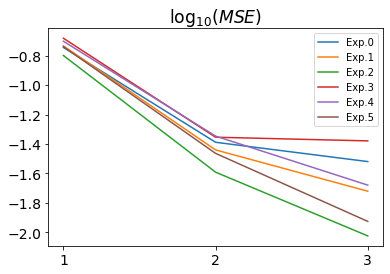

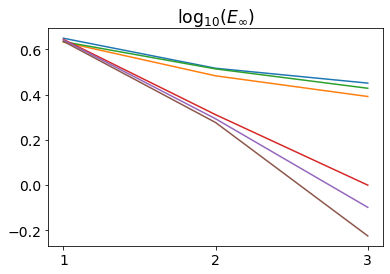

In [6]:
from mpl_toolkits.axes_grid1 import host_subplot

ax = host_subplot(111)
for i in range(MSE_history.shape[0]):
    x = np.arange(rounds) + 1
    MSE_log10 =torch.log10(MSE_history[i])
    
    text = 'Exp.' + str(i)
    
    ax.plot(x, MSE_log10, label = text)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (MSE)$', fontsize = 'xx-large')
plt.legend()
plt.show()

ax = host_subplot(111)
for i in range(L_inf_error_history.shape[0]):
    L_inf_log10 = torch.log10(L_inf_error_history[i])
    ax.plot(x, L_inf_log10)
    ax.set_xticks(x)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
plt.title('$\log_{10} (E_{\infty})$', fontsize = 'xx-large')
plt.show()